In [1]:
import numpy as np
import pandas as pd
from glob import glob as glob

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

# 1. Data Preparation

In [4]:
# Load target values and corresponding scaler
targets = pd.read_csv('datasets/targets.csv')
targets = targets.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
feature_transform = True

import joblib
scaler_targets = joblib.load('datasets/targets_scaler.pkl')

In [5]:
# Extract ID for train and test set
train_id = targets.index.values
sample_submission = pd.read_csv('sample_submission.csv')
test_id = np.unique(sample_submission.Id.str.split('_', expand=True)[0].astype('int'))

# 2. Modeling

In [6]:
def load_dataset(dataset_id, target):

    # Load dataset
    X_tr = pd.read_csv('datasets/%s_train.csv' % dataset_id)
    X_te = pd.read_csv('datasets/%s_test.csv' % dataset_id)

    # Specify target
    y = pd.read_csv('datasets/targets.csv')
    y = y.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
    y_tr = y.iloc[X_tr.index][target]

    # Remove missing values
    missval = y_tr.isnull().values
    idx = ~missval
    X_tr = X_tr[idx]
    y_tr = y_tr[idx]
    print('Removing %s missing values from target dataset.' % missval.sum())
    
    return X_tr, X_te, y_tr, idx

In [7]:
# Create scorer function
from sklearn.metrics import make_scorer
def model_metric(y_true, y_pred, scaler=None, tidx=0):
    t_true = scaler.inverse_transform(np.transpose([y_true] * 5))[:, tidx]
    t_pred = scaler.inverse_transform(np.transpose([y_pred] * 5))[:, tidx]
    
    if tidx == 0:
        age_values = np.unique(t_true)
        for i, a in enumerate(t_pred):
            t_pred[i] = age_values[np.argmin(np.abs(a-age_values))]

    if tidx > 0:
        t_true = np.power(t_true, 1./1.5)
        t_pred = np.power(t_pred, 1./1.5)
    score = np.mean(np.sum(np.abs(t_true - t_pred), axis=0) / np.sum(t_true, axis=0))
    return score

In [8]:
def create_grid(model_metric, estimator=None, cv=5, scaler_targets=None, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('estimator', estimator),
    ])

    # Define parameter grid
    Cs = np.logspace(-1.5, 1.5, 25)
    param_grid = [
    { 
        'scaler': [RobustScaler(),
                   PowerTransformer(),
                  ],
        'pca': [None],
        'estimator__C': Cs,
        'estimator__gamma': ['auto'],
        'estimator__kernel': ['rbf'],
        'estimator__cache_size': [2000],
    }
    ]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False, scaler=scaler_targets, tidx=tidx)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    return grid

In [9]:
def extract_predictions(X_tr, X_te, grid, target, targets, truncate_top=5):

    # Store predictions in dictionary
    res = {}
    res['tr'] = grid.predict(X_tr)
    res['te'] = grid.predict(X_te)

    # Assign age to correct bin
    if target == 'age':
        age_values = np.unique(targets.age)
        for t in ['tr', 'te']:
            age_pred_tr = res['%s' % t]
            for i, a in enumerate(age_pred_tr):
                age_pred_tr[i] = age_values[np.argmin(np.abs(a-age_values))]

    # Put upper and lower ceiling on predictions
    pred_order = res['te'].argsort()
    res['te'][pred_order[:truncate_top]] = res['te'][pred_order[truncate_top]]
    res['te'][pred_order[-truncate_top:]] = res['te'][pred_order[-truncate_top]]

    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    
    return res['tr'], res['te']

In [10]:
def plot_predictions(pred_tr, pred_te, y_tr):

    # Plot prediction descrepancy on training and test set
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.regplot(x=pred_tr, y=y_tr, marker='.', ax=ax[0])
    ax[0].set_title('Prediction X_tr: %s' % target)
    ax[0].set_xlim(ax[0].get_ylim())
    
    ax[1].plot(pred_te, '.', alpha=0.5)
    ax[1].plot(pred_tr, '.', alpha=0.3)
    ax[1].set_title('Prediction X_te: %s' % target)
    plt.show()

In [11]:
def create_df_pred(grid):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(grid.cv_results_)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    df_pred['param_scaler'] = df_pred['param_scaler'].astype('str')
    df_pred['param_pca'] = df_pred['param_pca'].astype('str')
    df_pred['param_estimator__C'] = df_pred['param_estimator__C'].astype('float')
    df_pred['param_estimator__gamma'] = df_pred['param_estimator__gamma'].astype('str')
    
    return df_pred

In [12]:
def plot_hyperparam_fitting(df_pred):

    # Plot the model fit information
    for p in df_pred['param_pca'].unique():
        for s in df_pred['param_scaler'].unique():
            for g in df_pred['param_estimator__gamma'].unique():

                df_plot = df_pred[np.prod([df_pred['param_pca']==p,
                                           df_pred['param_scaler']==s,
                                           df_pred['param_estimator__gamma']==g,
                                          ],
                                          axis=0).astype('bool')]
                df_plot = df_plot.sort_values('param_estimator__C')

                # Skip hyperparameter combination if not explored
                if df_plot.shape[0] == 0:
                    continue

                # Extract relevant modelling metrics
                train_scores = df_plot['mean_train_score']
                valid_scores = df_plot['mean_test_score']
                std_tr = df_plot['std_train_score']
                std_va = df_plot['std_test_score']

                plt.figure(figsize=(12, 4))
                alphas = df_plot['param_estimator__C']
                plt.semilogx(alphas, train_scores, label='Training Set')
                plt.semilogx(alphas, valid_scores, label='Validation Set')

                # Add marker and text for best score
                max_id = np.argmax(valid_scores)
                x_pos = alphas.iloc[max_id]
                y_pos = valid_scores.iloc[max_id]
                txt = '{:0.4f}'.format(y_pos)
                plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
                plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

                # Quantify variance with ±std curves
                plt.fill_between(alphas, train_scores-std_tr, train_scores+std_tr, alpha=0.3)
                plt.fill_between(alphas, valid_scores-std_va, valid_scores+std_va, alpha=0.3)
                plt.ylabel('Performance metric')
                plt.xlabel('Model parameter')

                # Adjust x-lim, y-lim, add legend and adjust layout
                plt.legend()
                plt.title('%s\n%s\n%s' % (str(s), str(p), str(g)))
                plt.show()

In [13]:
def run_prediction(model_metric, dataset_id='merge', target='age', estimator=None, scaler_targets=None, tidx=0):
    
    # Extract dataset
    X_tr, X_te, y_tr, idx = load_dataset(dataset_id, target)
    print('Size of dataset: ', X_tr.shape)
    
    # Create grid search object
    grid = create_grid(model_metric, estimator=estimator, scaler_targets=scaler_targets, tidx=tidx)
    
    # Run grid search
    res = grid.fit(X_tr, y_tr)
    
    # Compute predictions
    pred_tr, pred_te = extract_predictions(X_tr, X_te, grid, target, targets)
    
    # Plot predictions
    plot_predictions(pred_tr, pred_te, y_tr)
    
    # Create prediction dataframe
    df_pred = create_df_pred(grid)
    
    # Plot prediction behaviour
    plot_hyperparam_fitting(df_pred)
    
    return df_pred, pred_tr, pred_te, grid, idx

In [14]:
def display_grid_optimization_details(grid):
    df_cv = pd.DataFrame(grid.cv_results_)
    selecter = df_cv.columns.str.contains('param_') + \
               df_cv.columns.str.contains('mean') + \
               df_cv.columns.str.contains('std')
    df_cv = df_cv.loc[:, selecter]
    df_cv = df_cv.loc[:, ~df_cv.columns.str.contains('_time')]
    display(df_cv.sort_values('mean_test_score', ascending=False)[:20])

In [15]:
def create_results_dataframe(predictions, scaler_targets, targets, test_id, feature_transform, res_type='_te'):

    # Collect results
    t_keys = [k for k in predictions.keys() if res_type in k]
    results = np.transpose([predictions[k] for k in t_keys])

    # Reset scaling
    results = scaler_targets.inverse_transform(results)

    # Store results in Dataframe
    if res_type=='_te':
        df_results = pd.DataFrame(results, columns=targets.columns)

    elif res_type=='_tr':
        # Get location of missing values
        miss_columns = [k for k in predictions.keys() if 'miss' in k]
        entries = np.transpose([predictions[k] for k in miss_columns])

        # Create dataframe and fill up missing value places with NaN
        df_results = pd.concat(
            [pd.Series(dict(zip(train_id[entries[:, c]].astype('str'), results[c])))
             for c in range(len(miss_columns))], axis=1)
        df_results.columns = targets.columns

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    # Assign age to correct bin
    age_values = np.unique(scaler_targets.inverse_transform(targets)[:, 0])
    for i, a in enumerate(df_results.age):
        df_results.age[i] = age_values[np.argmin(np.abs(a-age_values))]

    # Add ID back to test results
    if res_type=='_te':
        df_results.insert(0, 'Id', test_id)
        df_results.set_index('Id', inplace=True)
    
    return df_results

In [16]:
def grids_summary(grids):

    grid_content = []
    for g in grids:

        column_name = []
        temp = []
        for k in g.best_params_:
            column_name.append(k)
            temp.append(g.best_params_[k])
        column_name.insert(0, 'score')
        temp.insert(0, -np.round(g.best_score_, 6))
        grid_content.append(temp)


    df_grid = pd.DataFrame(grid_content, columns=column_name)
    display(df_grid)

In [17]:
def save_results(predictions, scaler_targets, targets, test_id, feature_transform,
                 sample_submission, dataset_id, score_postfix):
    
    # Get results dataframe
    df_results_tr = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_tr')
    df_results_te = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_te')
    
    # Store test results in CSV file
    score_postfix = '_'.join(np.array(score_postfix).astype('str'))
    submission = sample_submission.copy()
    submission['Predicted'] = np.ravel(df_results_te)
    submission.to_csv('results/submission_svr-rbf_age_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    
    # Store dataframes in CSV files
    df_results_tr.to_csv('results/results_tr_svr-rbf_age_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    df_results_te.to_csv('results/results_te_svr-rbf_age_%s_%s.csv' % (dataset_id, score_postfix), index=False)

    return df_results_tr, df_results_te

In [18]:
def plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te):
    
    # Recreate original target dataset
    df_results = pd.DataFrame(scaler_targets.inverse_transform(targets),
                              columns=targets.columns)

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    # Compare target distributions of train and test set
    for c in df_results.columns:
        plt.figure(figsize=(5, 5))
        plt.title(c)
        plt.hist(df_results[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_te[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_tr[c], bins=25, alpha=0.5, density=True)
        plt.legend(['orig', 'test', 'train'])
        plt.show()

In [19]:
# Show list of available datasets
sorted(glob('datasets/*train.csv'))

['datasets/brain_corr_raw_train.csv',
 'datasets/brain_corr_train.csv',
 'datasets/brain_value_train.csv',
 'datasets/brain_voxel_train.csv',
 'datasets/fnc_train.csv',
 'datasets/ica_train.csv',
 'datasets/long_corr_train.csv',
 'datasets/long_extratree_train.csv',
 'datasets/long_merge_train.csv',
 'datasets/long_scaled_train.csv',
 'datasets/merge_ica_fnc_corr_train.csv',
 'datasets/merge_ica_fnc_train.csv',
 'datasets/merge_ica_fnc_value_train.csv',
 'datasets/merge_ica_fnc_voxel_train.csv',
 'datasets/merge_train.csv',
 'datasets/scaled_ica_fnc_corr_train.csv',
 'datasets/scaled_ica_fnc_train.csv',
 'datasets/scaled_ica_fnc_value_train.csv',
 'datasets/scaled_ica_fnc_voxel_train.csv',
 'datasets/short_corr_train.csv',
 'datasets/short_extratree_train.csv',
 'datasets/short_merge_train.csv',
 'datasets/short_scaled_train.csv']

Starting with dataset merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5865, 1405)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 38.9min finished


Best: -0.147774 using {'estimator__C': 1.7782794100389228, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


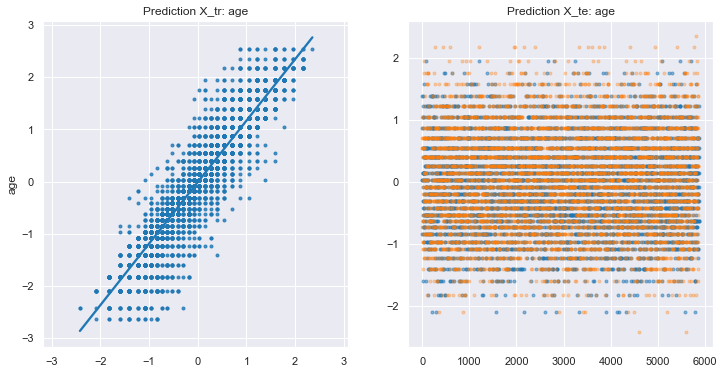

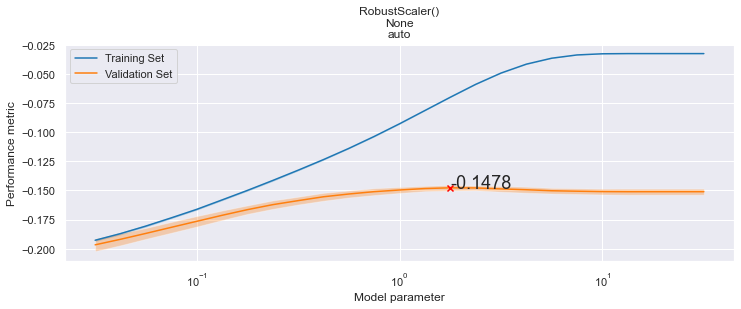

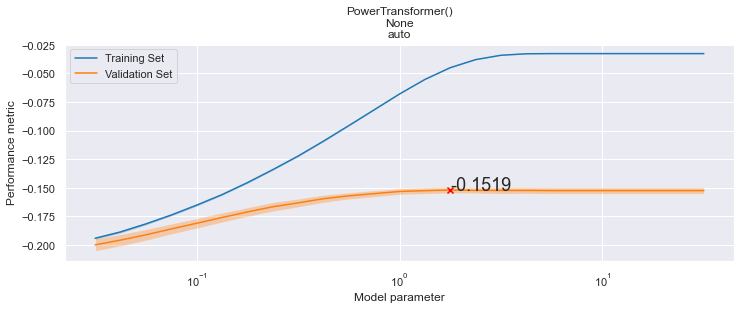

,param_estimator__C,param_estimator__cache_size,param_estimator__gamma,param_estimator__kernel,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
28,1.77828,2000,auto,rbf,None,RobustScaler(),-0.147774,0.002321,-0.070044,0.000385
30,2.37137,2000,auto,rbf,None,RobustScaler(),-0.147888,0.002006,-0.059002,0.000370
26,1.33352,2000,auto,rbf,None,RobustScaler(),-0.148405,0.002241,-0.081436,0.000438
32,3.16228,2000,auto,rbf,None,RobustScaler(),-0.148706,0.002396,-0.049285,0.000347
34,4.21697,2000,auto,rbf,None,RobustScaler(),-0.149426,0.002570,-0.041629,0.000420
24,1,2000,auto,rbf,None,RobustScaler(),-0.149656,0.002529,-0.092820,0.000541
36,5.62341,2000,auto,rbf,None,RobustScaler(),-0.150283,0.002395,-0.036519,0.000314
38,7.49894,2000,auto,rbf,None,RobustScaler(),-0.150682,0.002429,-0.033717,0.000242
40,10,2000,auto,rbf,None,RobustScaler(),-0.151013,0.002458,-0.032727,0.000174
22,0.749894,2000,auto,rbf,None,RobustScaler(),-0.151079,0.002910,-0.103691,0.000614


Starting with dataset merge - target: domain1_var1
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 34.5min finished


Best: -0.152407 using {'estimator__C': 0.5623413251903491, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': PowerTransformer()}


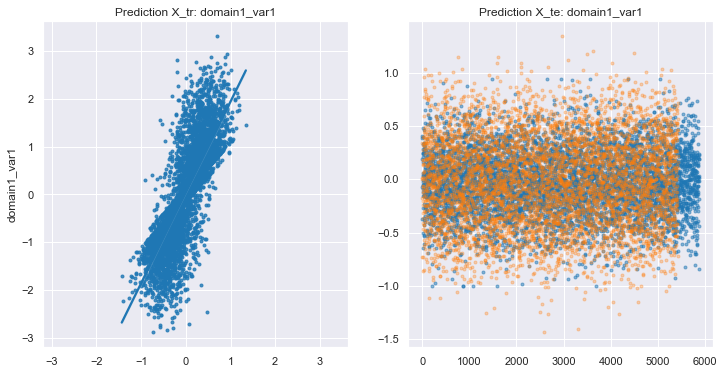

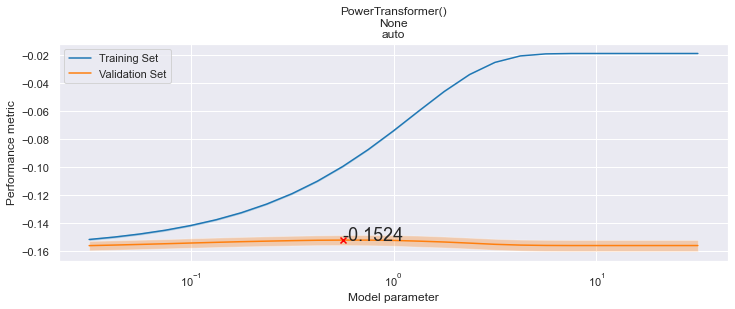

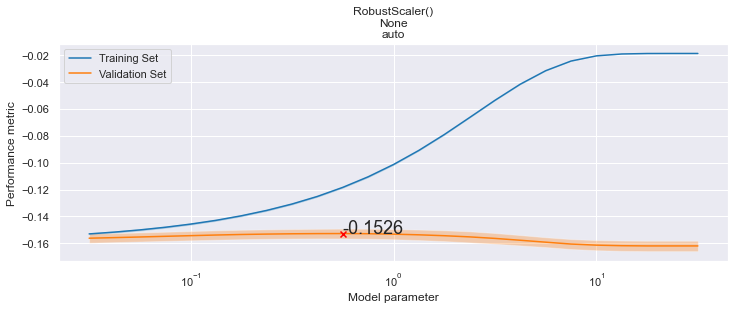

,param_estimator__C,param_estimator__cache_size,param_estimator__gamma,param_estimator__kernel,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
21,0.562341,2000,auto,rbf,None,PowerTransformer(),-0.152407,0.003542,-0.099798,0.000711
23,0.749894,2000,auto,rbf,None,PowerTransformer(),-0.152429,0.003655,-0.087760,0.000641
19,0.421697,2000,auto,rbf,None,PowerTransformer(),-0.152518,0.003483,-0.110295,0.000720
25,1,2000,auto,rbf,None,PowerTransformer(),-0.152641,0.003780,-0.074346,0.000558
20,0.562341,2000,auto,rbf,None,RobustScaler(),-0.152644,0.003634,-0.118400,0.000739
18,0.421697,2000,auto,rbf,None,RobustScaler(),-0.152691,0.003552,-0.125111,0.000754
22,0.749894,2000,auto,rbf,None,RobustScaler(),-0.152764,0.003689,-0.110571,0.000777
17,0.316228,2000,auto,rbf,None,PowerTransformer(),-0.152804,0.003454,-0.119228,0.000732
16,0.316228,2000,auto,rbf,None,RobustScaler(),-0.152819,0.003504,-0.130736,0.000776
14,0.237137,2000,auto,rbf,None,RobustScaler(),-0.153043,0.003487,-0.135476,0.000793


Starting with dataset merge - target: domain1_var2
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 34.5min finished


Best: -0.150715 using {'estimator__C': 0.05623413251903491, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


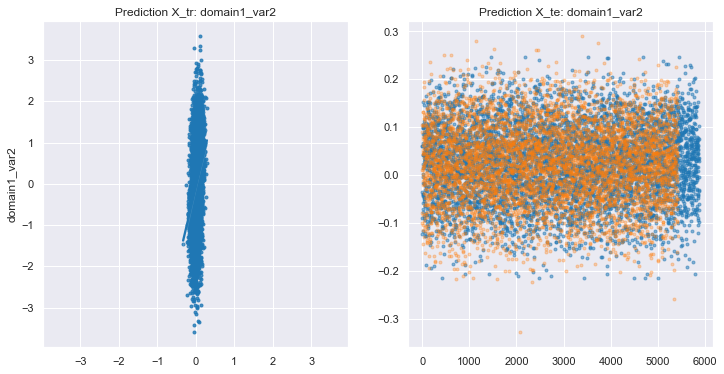

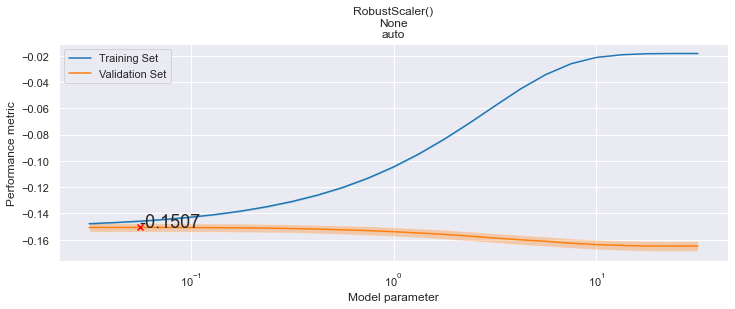

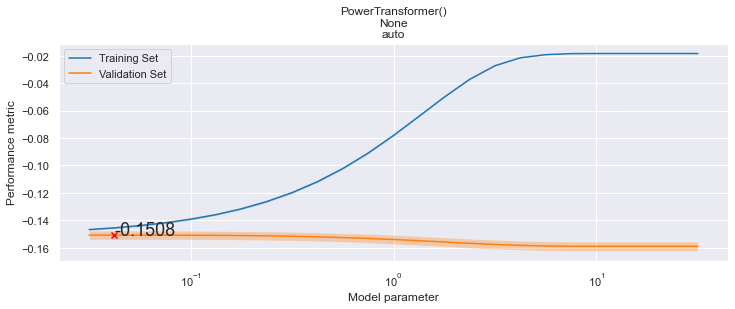

,param_estimator__C,param_estimator__cache_size,param_estimator__gamma,param_estimator__kernel,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
4,0.0562341,2000,auto,rbf,None,RobustScaler(),-0.150715,0.003281,-0.145933,0.000722
2,0.0421697,2000,auto,rbf,None,RobustScaler(),-0.150723,0.003287,-0.147006,0.000741
6,0.0749894,2000,auto,rbf,None,RobustScaler(),-0.150727,0.003278,-0.144582,0.000711
0,0.0316228,2000,auto,rbf,None,RobustScaler(),-0.150745,0.003296,-0.147863,0.000764
8,0.1,2000,auto,rbf,None,RobustScaler(),-0.150773,0.003285,-0.142900,0.000703
3,0.0421697,2000,auto,rbf,None,PowerTransformer(),-0.150789,0.003296,-0.145484,0.000751
5,0.0562341,2000,auto,rbf,None,PowerTransformer(),-0.150792,0.003292,-0.143870,0.000729
1,0.0316228,2000,auto,rbf,None,PowerTransformer(),-0.150798,0.003307,-0.146738,0.000769
7,0.0749894,2000,auto,rbf,None,PowerTransformer(),-0.150812,0.003287,-0.141807,0.000712
9,0.1,2000,auto,rbf,None,PowerTransformer(),-0.150870,0.003290,-0.139172,0.000701


Starting with dataset merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 39.8min finished


Best: -0.182022 using {'estimator__C': 0.23713737056616552, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


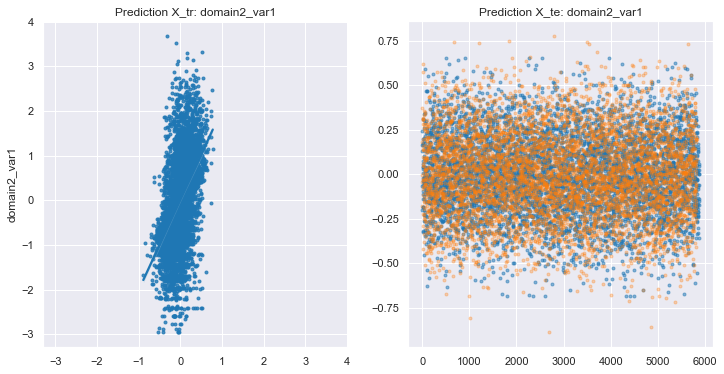

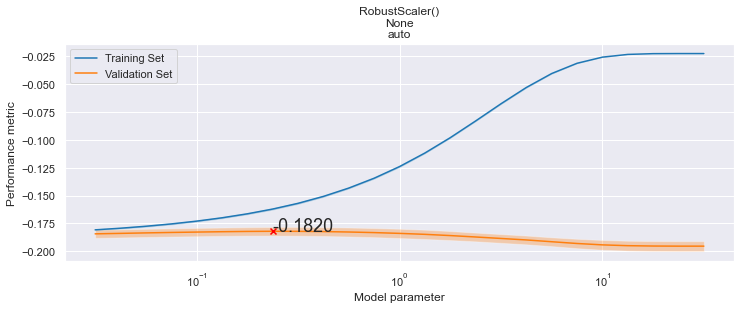

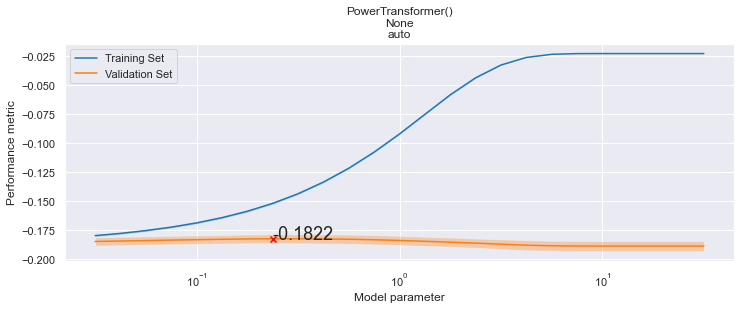

,param_estimator__C,param_estimator__cache_size,param_estimator__gamma,param_estimator__kernel,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
14,0.237137,2000,auto,rbf,None,RobustScaler(),-0.182022,0.003874,-0.162086,0.000975
16,0.316228,2000,auto,rbf,None,RobustScaler(),-0.182078,0.003922,-0.156959,0.000981
12,0.177828,2000,auto,rbf,None,RobustScaler(),-0.182153,0.003780,-0.166359,0.000943
15,0.237137,2000,auto,rbf,None,PowerTransformer(),-0.182195,0.003812,-0.151702,0.000918
17,0.316228,2000,auto,rbf,None,PowerTransformer(),-0.182213,0.003860,-0.143418,0.000863
18,0.421697,2000,auto,rbf,None,RobustScaler(),-0.182297,0.003940,-0.150749,0.000948
19,0.421697,2000,auto,rbf,None,PowerTransformer(),-0.182347,0.003891,-0.133374,0.000787
13,0.177828,2000,auto,rbf,None,PowerTransformer(),-0.182361,0.003737,-0.158492,0.000928
10,0.133352,2000,auto,rbf,None,RobustScaler(),-0.182413,0.003728,-0.169930,0.000924
21,0.562341,2000,auto,rbf,None,PowerTransformer(),-0.182614,0.003938,-0.121439,0.000767


Starting with dataset merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 39.5min finished


Best: -0.176227 using {'estimator__C': 0.1778279410038923, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


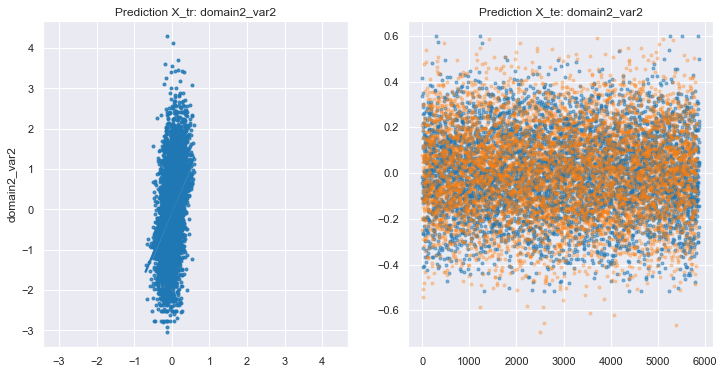

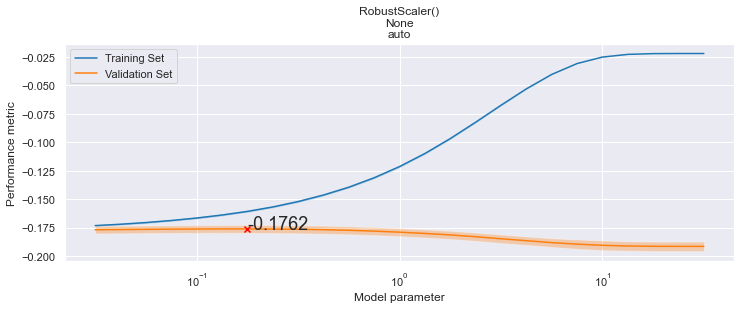

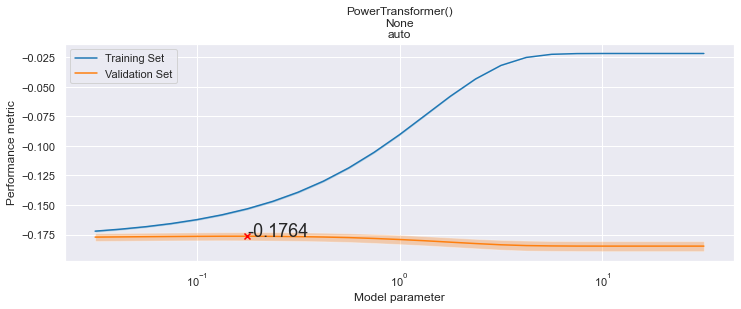

,param_estimator__C,param_estimator__cache_size,param_estimator__gamma,param_estimator__kernel,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
12,0.177828,2000,auto,rbf,None,RobustScaler(),-0.176227,0.003451,-0.160829,0.000918
10,0.133352,2000,auto,rbf,None,RobustScaler(),-0.176241,0.003380,-0.164009,0.000904
8,0.1,2000,auto,rbf,None,RobustScaler(),-0.176313,0.003355,-0.166650,0.000882
14,0.237137,2000,auto,rbf,None,RobustScaler(),-0.176345,0.003521,-0.156933,0.000933
13,0.177828,2000,auto,rbf,None,PowerTransformer(),-0.176443,0.003516,-0.153266,0.000942
6,0.0749894,2000,auto,rbf,None,RobustScaler(),-0.176445,0.003321,-0.168838,0.000861
11,0.133352,2000,auto,rbf,None,PowerTransformer(),-0.176451,0.003431,-0.158347,0.000920
9,0.1,2000,auto,rbf,None,PowerTransformer(),-0.176551,0.003374,-0.162456,0.000891
15,0.237137,2000,auto,rbf,None,PowerTransformer(),-0.176557,0.003580,-0.146975,0.000946
16,0.316228,2000,auto,rbf,None,RobustScaler(),-0.176561,0.003510,-0.152171,0.000926


,score,estimator__C,estimator__cache_size,estimator__gamma,estimator__kernel,pca,scaler
0,0.147774,1.778279,2000,auto,rbf,None,RobustScaler()
1,0.152407,0.562341,2000,auto,rbf,None,PowerTransformer()
2,0.150715,0.056234,2000,auto,rbf,None,RobustScaler()
3,0.182022,0.237137,2000,auto,rbf,None,RobustScaler()
4,0.176227,0.177828,2000,auto,rbf,None,RobustScaler()


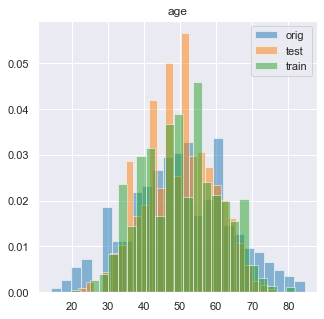

/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


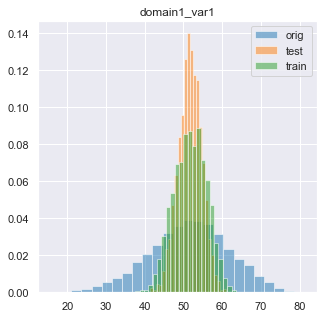

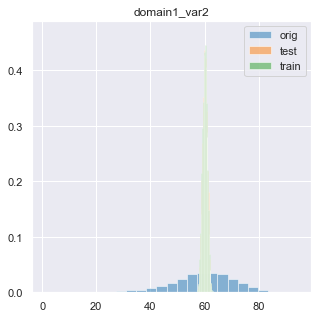

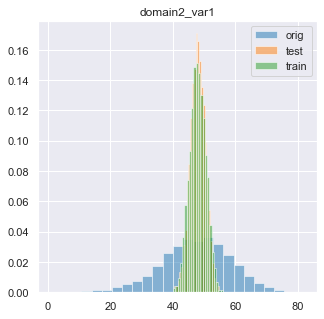

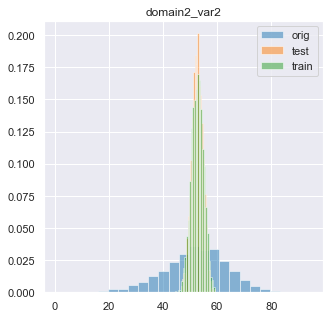

Score: 0.1601 | -0.1478 -0.1524 -0.1507 -0.1820 -0.1762


In [20]:
datasets_to_check = ['merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = SVR()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)

In [40]:
def create_grid(model_metric, estimator=None, cv=5, scaler_targets=None, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('estimator', estimator),
    ])

    # Define parameter grid
    Cs = np.logspace(0.3, 0.4, 4)
    param_grid = [
    { 
        'scaler': [RobustScaler()],
        'pca': [None],
        'estimator__C': Cs,
        'estimator__gamma': ['auto'],
        'estimator__kernel': ['rbf'],
        'estimator__cache_size': [2000],
    }
    ]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False, scaler=scaler_targets, tidx=tidx)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    return grid

Starting with dataset short_merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5825, 1655)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.2min finished


Best: -0.146997 using {'estimator__C': 2.154434690031884, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


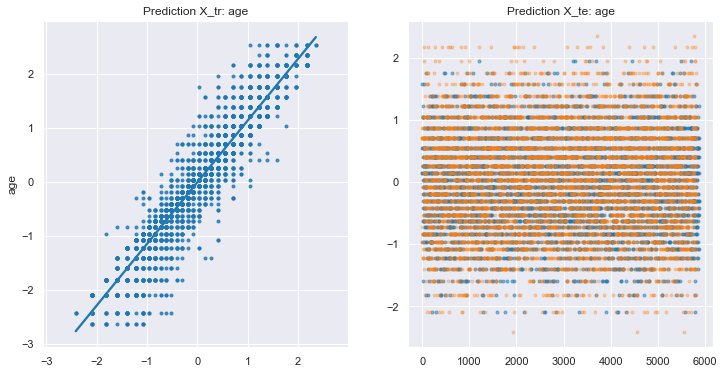

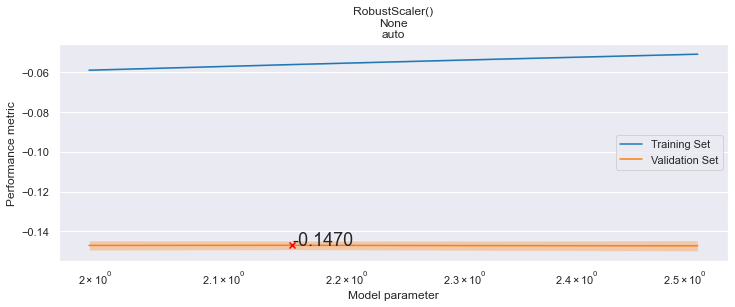

,param_estimator__C,param_estimator__cache_size,param_estimator__gamma,param_estimator__kernel,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
1,2.15443,2000,auto,rbf,None,RobustScaler(),-0.146997,0.002359,-0.056248,0.000351
0,1.99526,2000,auto,rbf,None,RobustScaler(),-0.147056,0.002490,-0.059082,0.000344
2,2.32631,2000,auto,rbf,None,RobustScaler(),-0.147156,0.002472,-0.053575,0.000408
3,2.51189,2000,auto,rbf,None,RobustScaler(),-0.147245,0.002710,-0.051043,0.000317


Starting with dataset short_merge - target: domain1_var1
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 12.6min finished


Best: -0.152498 using {'estimator__C': 1.9952623149688795, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


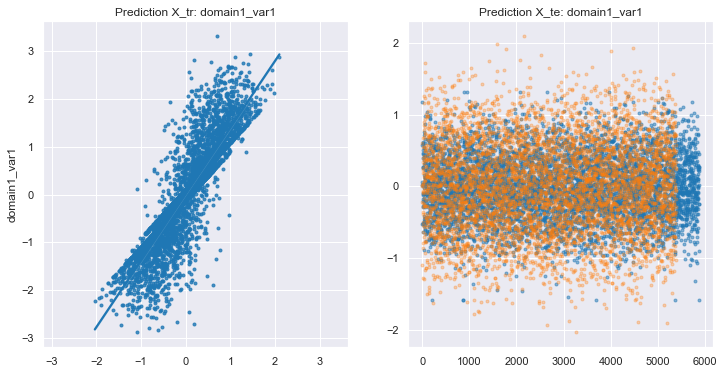

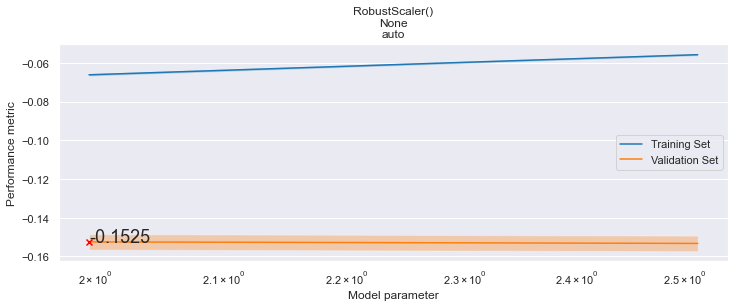

,param_estimator__C,param_estimator__cache_size,param_estimator__gamma,param_estimator__kernel,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
0,1.99526,2000,auto,rbf,None,RobustScaler(),-0.152498,0.003993,-0.066139,0.000642
1,2.15443,2000,auto,rbf,None,RobustScaler(),-0.152743,0.003995,-0.062654,0.000616
2,2.32631,2000,auto,rbf,None,RobustScaler(),-0.153015,0.004000,-0.059184,0.000596
3,2.51189,2000,auto,rbf,None,RobustScaler(),-0.153286,0.004017,-0.055745,0.000594


Starting with dataset short_merge - target: domain1_var2
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 13.0min finished


Best: -0.151505 using {'estimator__C': 1.9952623149688795, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


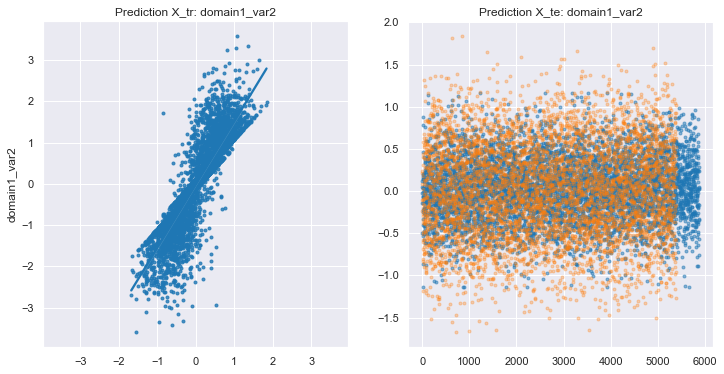

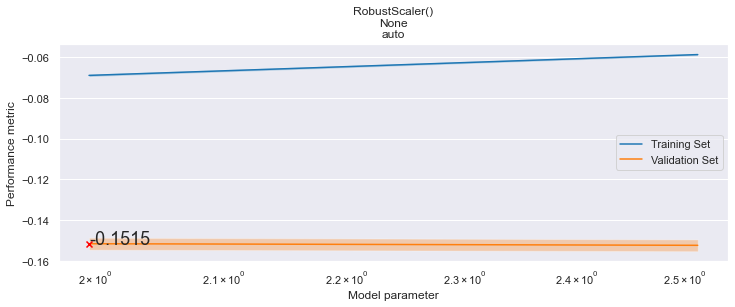

,param_estimator__C,param_estimator__cache_size,param_estimator__gamma,param_estimator__kernel,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
0,1.99526,2000,auto,rbf,None,RobustScaler(),-0.151505,0.002922,-0.068988,0.000590
1,2.15443,2000,auto,rbf,None,RobustScaler(),-0.151747,0.002916,-0.065615,0.000564
2,2.32631,2000,auto,rbf,None,RobustScaler(),-0.152013,0.002904,-0.062211,0.000537
3,2.51189,2000,auto,rbf,None,RobustScaler(),-0.152287,0.002885,-0.058789,0.000511


Starting with dataset short_merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 12.1min finished


Best: -0.182971 using {'estimator__C': 1.9952623149688795, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


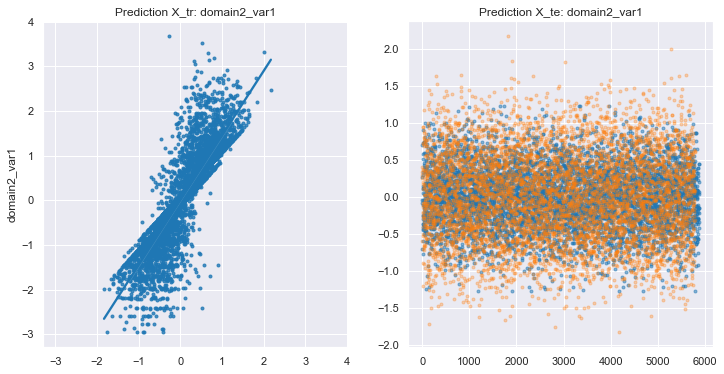

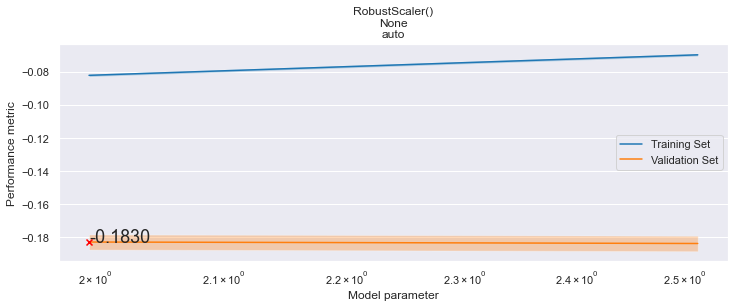

,param_estimator__C,param_estimator__cache_size,param_estimator__gamma,param_estimator__kernel,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
0,1.99526,2000,auto,rbf,None,RobustScaler(),-0.182971,0.004561,-0.082300,0.000767
1,2.15443,2000,auto,rbf,None,RobustScaler(),-0.183234,0.004603,-0.078182,0.000775
2,2.32631,2000,auto,rbf,None,RobustScaler(),-0.183532,0.004642,-0.074035,0.000782
3,2.51189,2000,auto,rbf,None,RobustScaler(),-0.183857,0.004655,-0.069916,0.000777


Starting with dataset short_merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 10.7min finished


Best: -0.178458 using {'estimator__C': 1.9952623149688795, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


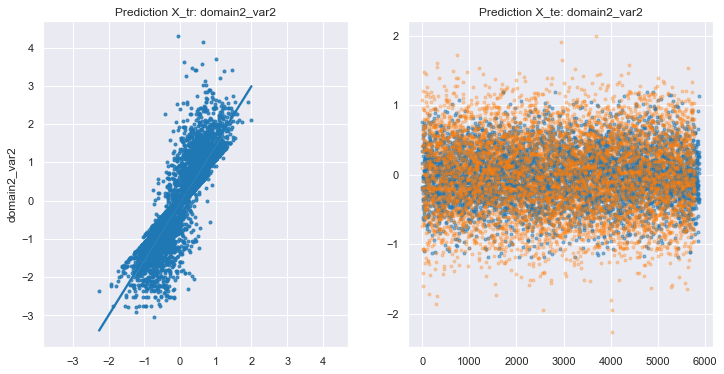

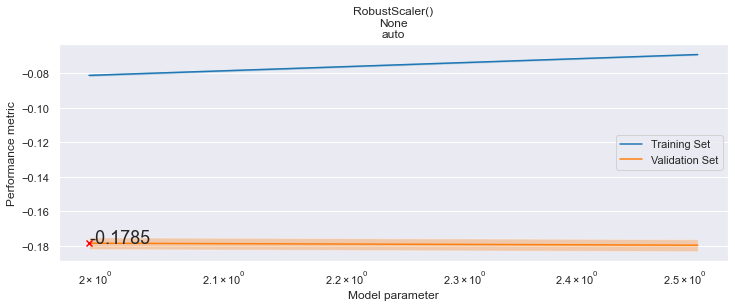

,param_estimator__C,param_estimator__cache_size,param_estimator__gamma,param_estimator__kernel,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
0,1.99526,2000,auto,rbf,None,RobustScaler(),-0.178458,0.003385,-0.081268,0.000701
1,2.15443,2000,auto,rbf,None,RobustScaler(),-0.178828,0.003426,-0.077275,0.000663
2,2.32631,2000,auto,rbf,None,RobustScaler(),-0.179207,0.003464,-0.073250,0.000620
3,2.51189,2000,auto,rbf,None,RobustScaler(),-0.179601,0.003475,-0.069207,0.000580


,score,estimator__C,estimator__cache_size,estimator__gamma,estimator__kernel,pca,scaler
0,0.146997,2.154435,2000,auto,rbf,None,RobustScaler()
1,0.152498,1.995262,2000,auto,rbf,None,RobustScaler()
2,0.151505,1.995262,2000,auto,rbf,None,RobustScaler()
3,0.182971,1.995262,2000,auto,rbf,None,RobustScaler()
4,0.178458,1.995262,2000,auto,rbf,None,RobustScaler()


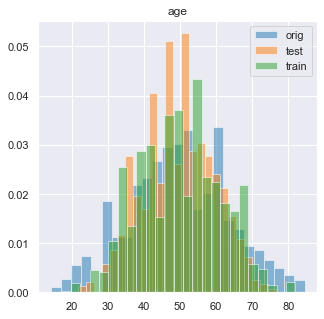

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


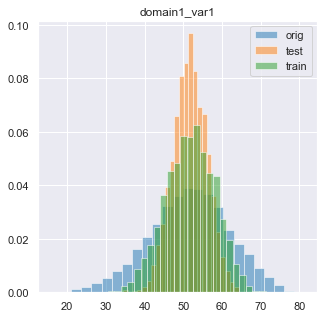

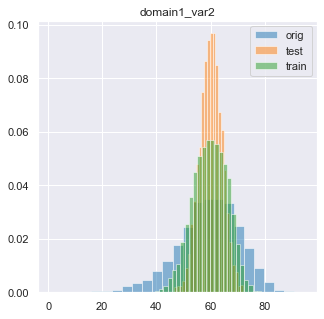

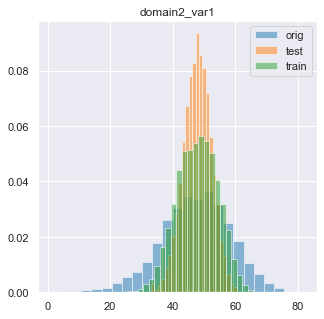

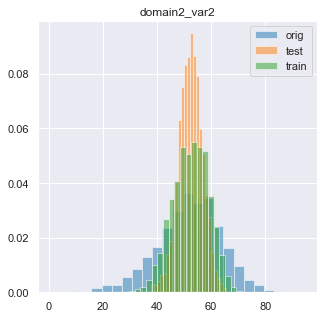

Score: 0.1605 | -0.1470 -0.1525 -0.1515 -0.1830 -0.1785


In [42]:
datasets_to_check = ['short_merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = SVR()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)